In [1]:
import matplotlib.pyplot as plt
import numpy as np

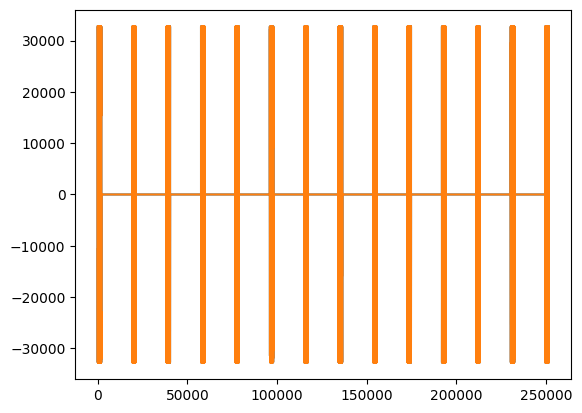

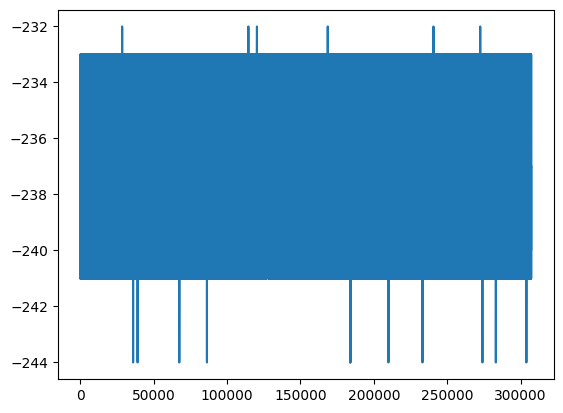

In [3]:
from testing.gain_patterns.collect import get_tone_ladder_recording

freq_spacing = 2500
freqs = range(15000, 50000, freq_spacing)
tone_length = 1e4
silence_length = 9e4

signal = get_tone_ladder_recording(freqs, tone_length, silence_length)
signal = signal.flatten().astype(np.int32)
plt.plot(signal)

In [6]:
from wavio import read

from testing.gain_patterns.models import Experiment, ExperimentEntry

exp = Experiment.load_by_name("first")
entry = ExperimentEntry(experiment=exp, azimuth=30, trial=0)
signal = read(entry.wav_file_path).data.flatten()
signal

array([-237, -237, -237, ..., -240, -240, -240], dtype=int16)

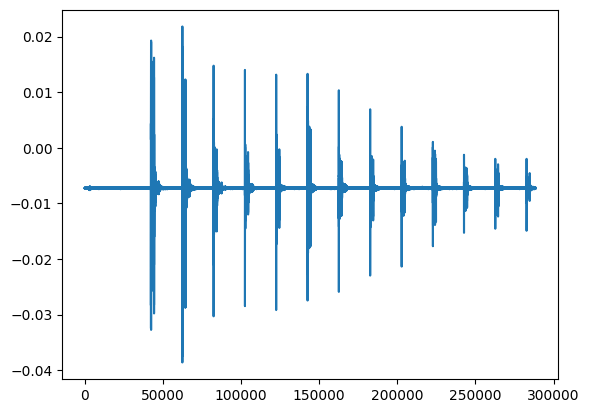

In [4]:
original_dtype = signal.dtype


# Normalization factor based on the maximum value of the input dtype
dtype_max = np.iinfo(original_dtype).max if np.issubdtype(original_dtype, np.integer) else 1.0

# Convert to float32 and normalize
normalized_signal = signal.astype(np.float32) / dtype_max

plt.plot(normalized_signal)

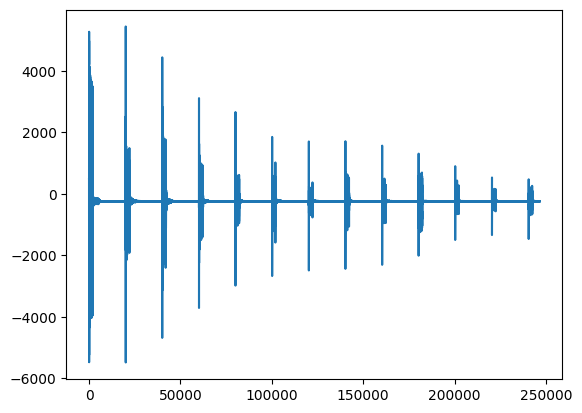

In [7]:
from robin.process.analyze import remove_leading_silence

plt.plot(remove_leading_silence(signal, -40))

0.0008848023372782395


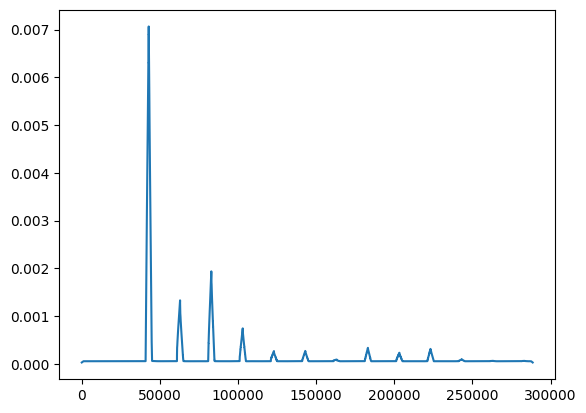

In [28]:
threshold_db = -15
filter_window_length = 2000

# Square each element to get signal power timeseries
power_signal = np.square(normalized_signal)

# Compute threshold power
threshold_power = np.max(power_signal) * 10 ** (threshold_db / 10)
print(threshold_power)

# Apply low-pass filtering on the power signal
window = np.ones(filter_window_length) / filter_window_length
filtered_power_signal = np.convolve(power_signal, window, mode='same')

plt.plot(filtered_power_signal)

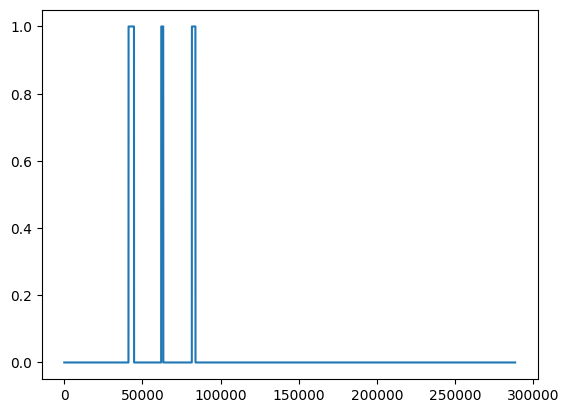

In [29]:
# Map each element to 0 or 1 based on threshold
thresholded_signal = (filtered_power_signal > threshold_power).astype(int)

plt.plot(thresholded_signal)

In [7]:
non_silent_segments = []
start = None
for i, value in enumerate(thresholded_signal):
    if value == 1 and start is None:
        start = i
    elif value == 0 and start is not None:
        segment = normalized_signal[start:i] * dtype_max
        non_silent_segments.append(segment.astype(original_dtype))
        start = None
if start is not None:
    segment = normalized_signal[start:] * dtype_max
    non_silent_segments.append(segment.astype(original_dtype))

(len(freqs), len(non_silent_segments))

NameError: name 'freqs' is not defined

In [ ]:
segs_and_idxs = []
for idx, segment in enumerate(non_silent_segments):
    segs_and_idxs.append((segment, idx))
segs_by_length = list(sorted(segs_and_idxs, key=lambda pair: -len(pair[0])))
longest_segs_unsorted = segs_by_length[0:len(freqs)]
tone_segments = [pair[0] for pair in list(sorted(longest_segs_unsorted, key=lambda pair: pair[1]))]

In [ ]:
from robin.util import bandpass

powers = {}
for idx, freq in enumerate(freqs):
    segment = tone_segments[idx].astype(np.int32)
    segment = bandpass(segment, freq - freq_spacing / 4, freq + freq_spacing / 4, 192000)
    power = np.sum(segment ** 2) / len(segment)
    powers[freq] = power

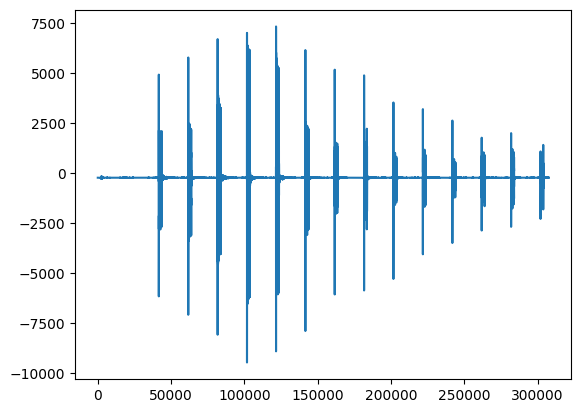

In [ ]:
plt.plot(signal)

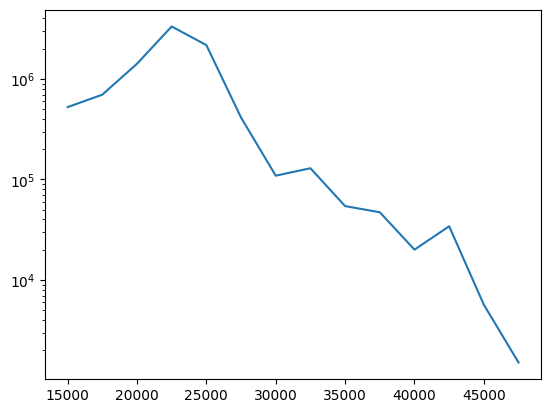

In [ ]:
plt.yscale("log")
plt.plot(powers.keys(), powers.values())